# Cellular neighborhood analysis of cells in both slides 991 and 992
**Goal:**  Retrieve and replot old RCNs, new ones are not the same, need to align to collection annotations  
**Input:** Merged adata from 991 and 992    
**Output:** Cellular neighborhood categories for all cells     
**Author:** Jose Nimo    
**Date_of_creation:** 17.05.2025     
**Date_of_latest_modification:** 17.05.2025    
**Status:** In Progress

# Setup and imports

In [1]:
import os,sys,time
from loguru import logger 

# import scimap as sm

import numpy as np
import pandas as pd
import shapely
import geopandas as gpd
import anndata as ad

import pyarrow
import ast

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#custom functions
sys.path.append(os.path.abspath('/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/src/'))
from opendvp import anndata_utils, filtering, imaging, utils
import importlib

for package in [np,pd,gpd,ad]:
    print(f"{package.__name__} {package.__version__}")

numpy 1.26.4
pandas 2.2.3
geopandas 1.0.1
anndata 0.10.9


# Try to retrieve

## adata 1

In [4]:
adata = ad.read_h5ad("../data/adatas/20241003_1656_991_992_phenotyped.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 1615233 × 8
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', 'filter_by_ann', 'mean_DAPI_bg_abs_above_value', 'mean_DAPI_bg_abs_below_value', 'Area_filter_nottoobig', 'Area_filter_nottoolow', 'Area_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'imageid', 'phenotype'
    var: 'math', 'marker'

In [2]:
adata = ad.read_h5ad("../data/adatas/20241004_1107_991_992_knn_RCN.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 1615233 × 8
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', 'filter_by_ann', 'mean_DAPI_bg_abs_above_value', 'mean_DAPI_bg_abs_below_value', 'Area_filter_nottoobig', 'Area_filter_nottoolow', 'Area_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'imageid', 'phenotype', 'spatial_lda_knn7_kmeans_k7', 'spatial_lda_knn14_kmeans_k7', 'spatial_lda_knn21_kmeans_k7', 'spatial_lda_knn30_kmeans_k7', 'spatial_lda_knn40_kmeans_k7', 'spatial_lda_knn50_kmeans_k7'
    var: 'math', 'marker'
    uns: 'spatial_lda_knn14', 'spatial_lda_knn14_probability', 'spatial_lda_knn21', 'spatial_lda_knn21_probability', 'spatial_lda_knn30', 'spatial_lda_knn30_probability', 'spatial_lda_knn40', 'spatial_lda_knn40_probability', 'spatial_lda_knn50', 'spatial_lda_knn50_probability', 'spatial_lda_knn7', 'spatial_lda_knn7_probability'

# Use KNN30 from replicate

In [6]:
adata = ad.read_h5ad("../data/perSample/991_992/1_spatial_LDA/20250303_1654_1_spatial_LDA_adata.h5ad")
adata

AnnData object with n_obs × n_vars = 1615233 × 8
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', 'artefact', 'Area_filter_nottoobig', 'Area_filter_nottoolow', 'Area_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'filtering', 'imageid', 'phenotype', 'cell_id', 'spatial_lda_knn7_kmeans_k7', 'spatial_lda_knn14_kmeans_k7', 'spatial_lda_knn21_kmeans_k7', 'spatial_lda_knn30_kmeans_k7', 'spatial_lda_knn40_kmeans_k7', 'spatial_lda_knn50_kmeans_k7'
    uns: 'spatial_lda_knn14', 'spatial_lda_knn14_probability', 'spatial_lda_knn21', 'spatial_lda_knn21_probability', 'spatial_lda_knn30', 'spatial_lda_knn30_probability', 'spatial_lda_knn40', 'spatial_lda_knn40_probability', 'spatial_lda_knn50', 'spatial_lda_knn50_probability', 'spatial_lda_knn7', 'spatial_lda_knn7_probability'
    layers: 'log'

In [9]:
help(anndata_utils.adataobs_to_voronoi_geojson)

Help on function adataobs_to_voronoi_geojson in module opendvp.anndata_utils:

adataobs_to_voronoi_geojson(adata, subset_adata_key=None, subset_adata_value=None, color_by_adata_key: str = 'phenotype', color_dict: dict = None, threshold_quantile=0.98, merge_adjacent_shapes=True, save_as_detection=True, output_filepath: str = None)
    Generate a Voronoi diagram from cell centroids stored in an AnnData object 
    and export it as a GeoJSON file or return it as a GeoDataFrame.
    
    This function computes a 2D Voronoi tessellation from the 'X_centroid' and 'Y_centroid' 
    columns in `adata.obs`, optionally filters and merges polygons based on user-defined criteria, 
    and outputs the result in a GeoJSON-compatible format for visualization or downstream analysis 
    (e.g., in QuPath).
    
    Parameters
    ----------
    adata : AnnData
        AnnData object with centroid coordinates in `adata.obs[['X_centroid', 'Y_centroid']]`.
    
    subset_adata_key : str, optional
       

In [11]:
adata.obs.imageid.dtype

dtype('int64')

In [12]:
import json
with open("../assets/RCN_colors.json") as f:
    color_dict = json.load(f)
color_dict

{'0': '#FFA3FE',
 '1': '#F5887F',
 '2': '#5B5BDB',
 '3': '#8A7542',
 '4': '#959191',
 '5': '#FF973E',
 '6': '#AAFAB1'}

In [13]:
anndata_utils.adataobs_to_voronoi_geojson(
    adata = adata,
    subset_adata_key = "imageid", 
    subset_adata_value = 991,
    color_by_adata_key = "spatial_lda_knn30_kmeans_k7",
    color_dict = color_dict,
    threshold_quantile = 0.98,
    merge_adjacent_shapes = True,
    save_as_detection = True,  
    output_filepath = "../data/perSample/991/qc/20250517_991_voronoi_RCN_knn30_replicate.geojson"
)

2025-05-17 14:00:33.550 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:277 - [991 992]
2025-05-17 14:00:33.551 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:278 - Subset adata col dtype: int64
2025-05-17 14:00:33.620 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:280 -  Shape after subset: (610182, 28)
2025-05-17 14:00:33.621 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:283 - Running Voronoi
2025-05-17 14:01:11.388 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:286 - Voronoi done
2025-05-17 14:01:11.495 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:290 - Transformed to geodataframe
2025-05-17 14:01:11.499 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:295 - Bounding box: x_min: 878.0, x_max: 71605.3, y_min: 6.8, y_max 42764.7
2025-05-17 14:01:12.753 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:300 - Retaining 609923 valid polygons after filtering large a

## Barplots

### Composition barplots

/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_11969/1273600839.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total = df.groupby([x_axis, y_axis]).size().unstack().fillna(0).sum(axis=1)
/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_11969/1273600839.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([x_axis, y_axis]).size().unstack().fillna(0).div(total, axis=0).stack())


Figure saved as: ../figures/RCN_bar_plot/20250517_1452_RCN_bar_knn30_withUnknowns.pdf and ../figures/RCN_bar_plot/20250517_1452_RCN_bar_knn30_withUnknowns.svg


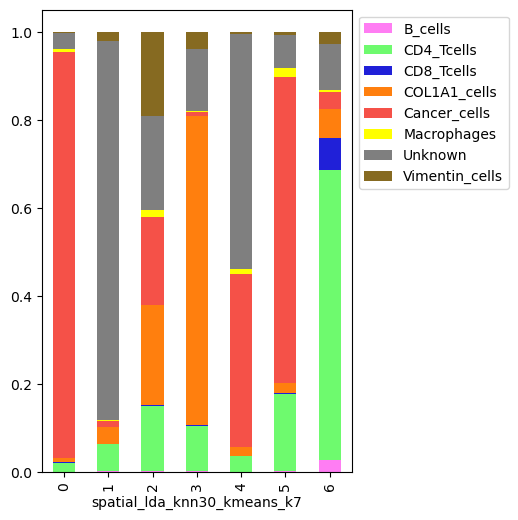

In [26]:
adata = ad.read_h5ad("../data/perSample/991_992/2_spatial_distance/20250411_1544_2_spatial_distance_adata.h5ad")

x_axis = "spatial_lda_knn30_kmeans_k7"
y_axis = "phenotype"

df = pd.DataFrame(data = adata.obs[[x_axis, y_axis]])

total = df.groupby([x_axis, y_axis]).size().unstack().fillna(0).sum(axis=1)

rg = pd.DataFrame(
    df.groupby([x_axis, y_axis]).size().unstack().fillna(0).div(total, axis=0).stack())
rg.columns = ['count']
rg.reset_index(inplace=True)
pivot_df = rg.pivot(index=x_axis, columns=y_axis, values="count")

# load colors
import json
with open("../assets/pheno_colors.json") as f:
    pheno_colors = json.load(f)
pheno_colors

fig,ax = plt.subplots()
fig.set_size_inches(4, 6)
pivot_df.plot.bar(
                color=pheno_colors, 
                stacked=True, 
                ax=ax, 
                linewidth=0.3)

plt.legend(bbox_to_anchor=(1,1))
utils.export_figure(fig, "../figures/RCN_bar_plot/", suffix="RCN_bar_knn30_withUnknowns")
plt.show()

/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_11969/291760003.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total = df.groupby([x_axis, y_axis]).size().unstack().fillna(0).sum(axis=1)
/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_11969/291760003.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([x_axis, y_axis]).size().unstack().fillna(0).div(total, axis=0).stack())


Figure saved as: ../figures/RCN_bar_plot/20250517_1452_RCN_bar_knn30_withoutUnknowns.pdf and ../figures/RCN_bar_plot/20250517_1452_RCN_bar_knn30_withoutUnknowns.svg


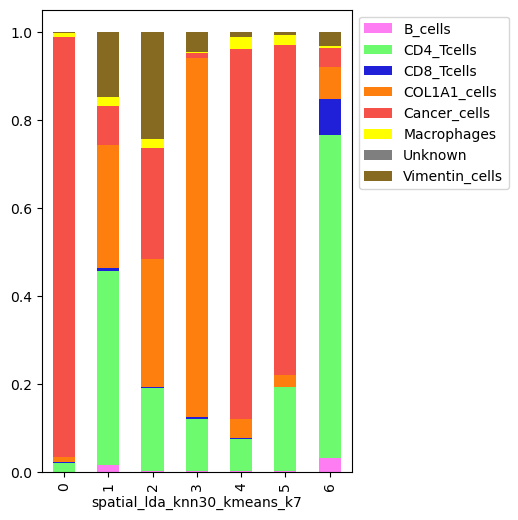

In [27]:
adata = ad.read_h5ad("../data/perSample/991_992/2_spatial_distance/20250411_1544_2_spatial_distance_adata.h5ad")

x_axis = "spatial_lda_knn30_kmeans_k7"
y_axis = "phenotype"

df = pd.DataFrame(data = adata.obs[[x_axis, y_axis]])

df = df[df['phenotype'] != "Unknown"]

total = df.groupby([x_axis, y_axis]).size().unstack().fillna(0).sum(axis=1)

rg = pd.DataFrame(
    df.groupby([x_axis, y_axis]).size().unstack().fillna(0).div(total, axis=0).stack())
rg.columns = ['count']
rg.reset_index(inplace=True)
pivot_df = rg.pivot(index=x_axis, columns=y_axis, values="count")

# load colors
import json
with open("../assets/pheno_colors.json") as f:
    pheno_colors = json.load(f)
pheno_colors

fig,ax = plt.subplots()
fig.set_size_inches(4, 6)
pivot_df.plot.bar(
                color=pheno_colors, 
                stacked=True, 
                ax=ax, 
                linewidth=0.3)

plt.legend(bbox_to_anchor=(1,1))
utils.export_figure(fig, "../figures/RCN_bar_plot/", suffix="RCN_bar_knn30_withoutUnknowns")
plt.show()

## barplot per slide

/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_11969/2889502342.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_991 = df_991.groupby([x_axis]).size()
/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_11969/2889502342.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_992 = df_992.groupby([x_axis]).size()
/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_11969/2889502342.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to ad

Figure saved as: ../figures/RCN_bar_plot/20250517_1426_RCN_bar_perSample_relative_withUnknowns.pdf and ../figures/RCN_bar_plot/20250517_1426_RCN_bar_perSample_relative_withUnknowns.svg


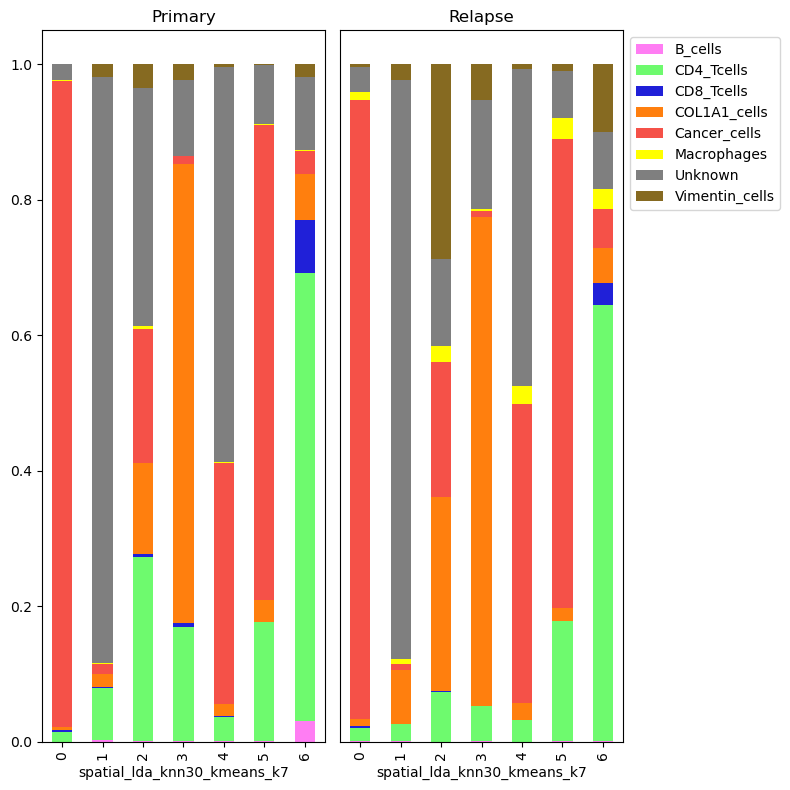

In [15]:
adata = ad.read_h5ad("../data/perSample/991_992/2_spatial_distance/20250411_1544_2_spatial_distance_adata.h5ad")

x_axis = "spatial_lda_knn30_kmeans_k7"
y_axis = "phenotype"
plot_axis = "imageid"

df = pd.DataFrame(data = adata.obs[[x_axis, y_axis, plot_axis]])

df_991 = df[df['imageid']==991]
df_992 = df[df['imageid']==992]

total_991 = df_991.groupby([x_axis]).size()
total_992 = df_992.groupby([x_axis]).size()

rg_991 = pd.DataFrame(df_991.groupby([x_axis, y_axis]).size().unstack().fillna(0).div(total_991, axis=0).stack())
rg_991.columns = ['count']
rg_991.reset_index(inplace=True)
pivot_df_991 = rg_991.pivot(index=x_axis, columns=y_axis, values="count")

rg_992 = pd.DataFrame(df_992.groupby([x_axis, y_axis]).size().unstack().fillna(0).div(total_992, axis=0).stack())
rg_992.columns = ['count']
rg_992.reset_index(inplace=True)
pivot_df_992 = rg_992.pivot(index=x_axis, columns=y_axis, values="count")

fig,ax = plt.subplots(ncols=2, nrows=1, sharey=True)
fig.set_size_inches(8, 8)

pivot_df_991.plot.bar(
                color=pheno_colors, 
                stacked=True, 
                ax=ax[0], 
                #  edgecolor='none', 
                linewidth=0.3)

pivot_df_992.plot.bar(
                color=pheno_colors, 
                stacked=True, 
                ax=ax[1], 
                #  edgecolor='none', 
                linewidth=0.3)

ax[0].legend().set_visible(False)

#titles
ax[0].set_title("Primary")
ax[1].set_title("Relapse")
ax[1].yaxis.set_visible(False)
plt.legend(bbox_to_anchor=(1,1))
# utils.export_figure(fig, "../figures/RCN_bar_plot/", suffix="RCN_bar_perSample_relative_withUnknowns")
plt.tight_layout()
plt.show()

/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_11969/1891532972.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_991 = df_991.groupby([x_axis]).size()
/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_11969/1891532972.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_992 = df_992.groupby([x_axis]).size()
/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_11969/1891532972.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to ad

Figure saved as: ../figures/RCN_bar_plot/20250517_1451_RCN_bar_perSample_relative_withoutUnknowns.pdf and ../figures/RCN_bar_plot/20250517_1451_RCN_bar_perSample_relative_withoutUnknowns.svg


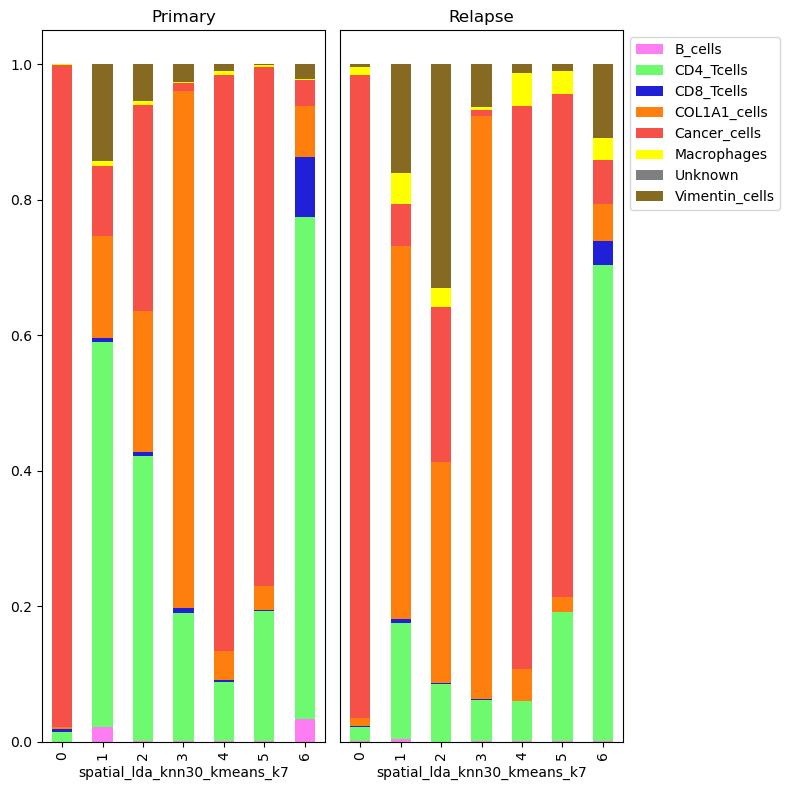

In [25]:
adata = ad.read_h5ad("../data/perSample/991_992/2_spatial_distance/20250411_1544_2_spatial_distance_adata.h5ad")

x_axis = "spatial_lda_knn30_kmeans_k7"
y_axis = "phenotype"
plot_axis = "imageid"

df = pd.DataFrame(data = adata.obs[[x_axis, y_axis, plot_axis]])

df_991 = df[df['imageid']==991]
df_992 = df[df['imageid']==992]

#remove unknowns
df_991 = df_991[df_991['phenotype'] != "Unknown"]
df_992 = df_992[df_992['phenotype'] != "Unknown"]

total_991 = df_991.groupby([x_axis]).size()
total_992 = df_992.groupby([x_axis]).size()

rg_991 = pd.DataFrame(df_991.groupby([x_axis, y_axis]).size().unstack().fillna(0).div(total_991, axis=0).stack())
rg_991.columns = ['count']
rg_991.reset_index(inplace=True)
pivot_df_991 = rg_991.pivot(index=x_axis, columns=y_axis, values="count")

rg_992 = pd.DataFrame(df_992.groupby([x_axis, y_axis]).size().unstack().fillna(0).div(total_992, axis=0).stack())
rg_992.columns = ['count']
rg_992.reset_index(inplace=True)
pivot_df_992 = rg_992.pivot(index=x_axis, columns=y_axis, values="count")

fig,ax = plt.subplots(ncols=2, nrows=1, sharey=True)
fig.set_size_inches(8, 8)

pivot_df_991.plot.bar(
                color=pheno_colors, 
                stacked=True, 
                ax=ax[0], 
                #  edgecolor='none', 
                linewidth=0.3)

pivot_df_992.plot.bar(
                color=pheno_colors, 
                stacked=True, 
                ax=ax[1], 
                #  edgecolor='none', 
                linewidth=0.3)

ax[0].legend().set_visible(False)

#titles
ax[0].set_title("Primary")
ax[1].set_title("Relapse")
ax[1].yaxis.set_visible(False)
plt.legend(bbox_to_anchor=(1,1))
utils.export_figure(fig, "../figures/RCN_bar_plot/", suffix="RCN_bar_perSample_relative_withoutUnknowns")
plt.tight_layout()
plt.show()

In [17]:
# choose new colors
with open("../assets/RCN_colors.json") as f:
    RCN_colors = json.load(f)
RCN_colors

{'0': '#FFA3FE',
 '1': '#F5887F',
 '2': '#5B5BDB',
 '3': '#8A7542',
 '4': '#959191',
 '5': '#FF973E',
 '6': '#AAFAB1'}

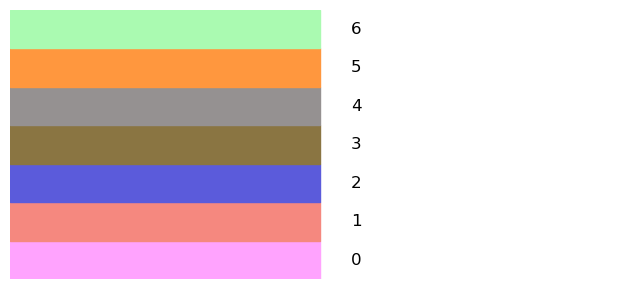

In [18]:
utils.print_color_dict(RCN_colors)

In [ ]:
new_RCN_colors = {
    "0": "#F5887F" , # old 1
    "1":  "#959191", # old 4
    "2":  "#8A7542", #old 3
    "3": "#FF973E", # old 5
    "4": "#FFA3FE", # old 0
    "5": "#5B5BDB", # old 2
    "6": "#AAFAB1", #stays 6
}

with open("../assets/20250517_new_RCN_colors.json", "w") as f:
    json.dump(new_RCN_colors, f, indent=4)

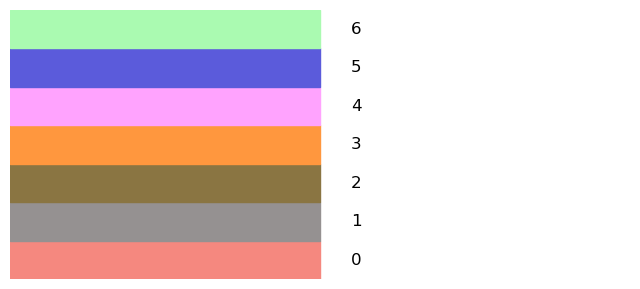

In [21]:
utils.print_color_dict(new_RCN_colors)

In [22]:
adata

AnnData object with n_obs × n_vars = 1615233 × 8
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', 'artefact', 'Area_filter_nottoobig', 'Area_filter_nottoolow', 'Area_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'filtering', 'imageid', 'phenotype', 'cell_id', 'spatial_lda_knn7_kmeans_k7', 'spatial_lda_knn14_kmeans_k7', 'spatial_lda_knn21_kmeans_k7', 'spatial_lda_knn30_kmeans_k7', 'spatial_lda_knn40_kmeans_k7', 'spatial_lda_knn50_kmeans_k7'
    uns: 'spatial_distance', 'spatial_interaction_radius', 'spatial_interaction_radius_perimage', 'spatial_lda_knn14', 'spatial_lda_knn14_probability', 'spatial_lda_knn21', 'spatial_lda_knn21_probability', 'spatial_lda_knn30', 'spatial_lda_knn30_probability', 'spatial_lda_knn40', 'spatial_lda_knn40_probability', 'spatial_lda_knn50', 'spatial_lda_knn50_probability', 'spatial_lda_knn7', 'spatial_lda_knn

In [23]:
## save new voronoi with new colors

anndata_utils.adataobs_to_voronoi_geojson(
    adata = adata,
    subset_adata_key = "imageid", 
    subset_adata_value = 991,
    color_by_adata_key = "spatial_lda_knn30_kmeans_k7",
    color_dict = new_RCN_colors,
    threshold_quantile = 0.98,
    merge_adjacent_shapes = True,
    save_as_detection = True,  
    output_filepath = "../data/perSample/991/qc/20250517_991_voronoi_RCN_knn30_newcolors.geojson"
)

2025-05-17 14:40:16.154 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:277 - [991 992]
2025-05-17 14:40:16.157 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:278 - Subset adata col dtype: int64
2025-05-17 14:40:16.203 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:280 -  Shape after subset: (610182, 28)
2025-05-17 14:40:16.203 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:283 - Running Voronoi
2025-05-17 14:40:54.498 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:286 - Voronoi done
2025-05-17 14:40:54.575 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:290 - Transformed to geodataframe
2025-05-17 14:40:54.578 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:295 - Bounding box: x_min: 878.0, x_max: 71605.3, y_min: 6.8, y_max 42764.7
2025-05-17 14:40:55.817 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:300 - Retaining 609923 valid polygons after filtering large a

### Plot CN Change with new colors and KNN30 RCNs

Figure saved as: ../figures/RCN_bar_plot/20250517_1500_CN_changes_proportion_per_imageid.pdf and ../figures/RCN_bar_plot/20250517_1500_CN_changes_proportion_per_imageid.svg


/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_11969/390843168.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = pd.DataFrame(df.groupby(["imageid", RCN]).size().div(total,axis=0))


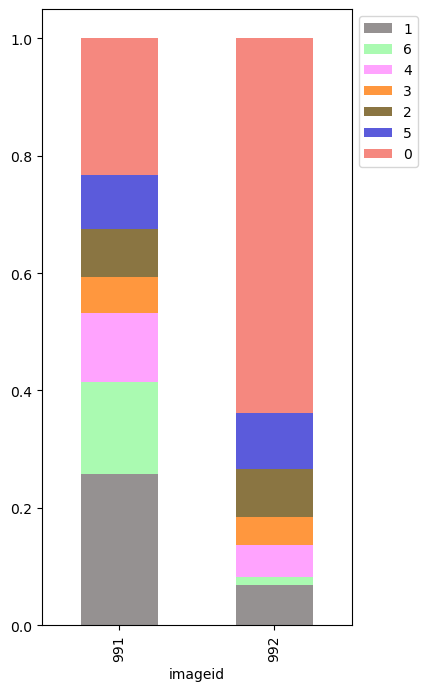

In [29]:
adata = ad.read_h5ad("../data/perSample/991_992/2_spatial_distance/20250411_1544_2_spatial_distance_adata.h5ad")

RCN = "spatial_lda_knn30_kmeans_k7"
df = adata.obs.copy()
df = df[["CellID", "imageid", "cell_id", "phenotype", RCN]]

total = df.groupby(["imageid"]).size()

counts = pd.DataFrame(df.groupby(["imageid", RCN]).size().div(total,axis=0))
counts.columns = ['proportion']
counts.reset_index(inplace=True)

x_axis = "imageid"
y_axis = RCN

pivot_df = counts.pivot(
    index = x_axis, 
    columns = y_axis, 
    values="proportion" )

df = pivot_df *100
df = df.T
df['diff'] = df[992] - df[991]
df_sorted = df.sort_values(by="diff", ascending=True)

fig,ax = plt.subplots()
fig.set_size_inches(4, 8)

pivot_df[df_sorted.index].plot.bar(
                color=new_RCN_colors, 
                stacked=True, 
                ax=ax, 
                linewidth=0.3)

plt.legend(bbox_to_anchor=(1,1))

utils.export_figure(fig, path="../figures/RCN_bar_plot", suffix="CN_changes_proportion_per_imageid", dpi=600 )

plt.show()

In [31]:
df_sorted

imageid,991,992,diff
spatial_lda_knn30_kmeans_k7,,,
1,25.746908,6.855970,-18.890938
6,15.619438,1.284313,-14.335125
4,11.809427,5.506785,-6.302642
3,6.111619,4.835377,-1.276243
2,8.170021,8.145159,-0.024863
5,9.281985,9.526382,0.244398
0,23.260601,63.846014,40.585413


## export 992 RCNs

In [32]:
new_RCN_colors

{'0': '#F5887F',
 '1': '#959191',
 '2': '#8A7542',
 '3': '#FF973E',
 '4': '#FFA3FE',
 '5': '#5B5BDB',
 '6': '#AAFAB1'}

In [33]:
adata = ad.read_h5ad("../data/perSample/991_992/2_spatial_distance/20250411_1544_2_spatial_distance_adata.h5ad")

In [34]:
## save new voronoi with new colors

anndata_utils.adataobs_to_voronoi_geojson(
    adata = adata,
    subset_adata_key = "imageid", 
    subset_adata_value = 992,
    color_by_adata_key = "spatial_lda_knn30_kmeans_k7",
    color_dict = new_RCN_colors,
    threshold_quantile = 0.98,
    merge_adjacent_shapes = True,
    save_as_detection = True,  
    output_filepath = "../data/perSample/992/qc/20250517_992_voronoi_RCN_knn30_newcolors.geojson"
)

2025-05-17 18:54:15.527 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:277 - [991 992]
2025-05-17 18:54:15.533 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:278 - Subset adata col dtype: int64
2025-05-17 18:54:15.629 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:280 -  Shape after subset: (1005051, 28)
2025-05-17 18:54:15.630 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:283 - Running Voronoi
2025-05-17 18:55:30.160 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:286 - Voronoi done
2025-05-17 18:55:30.381 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:290 - Transformed to geodataframe
2025-05-17 18:55:30.385 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:295 - Bounding box: x_min: 2217.0, x_max: 70848.8, y_min: 20.4, y_max 47085.0
2025-05-17 18:55:32.688 | INFO     | opendvp.anndata_utils:adataobs_to_voronoi_geojson:300 - Retaining 1003632 valid polygons after filtering lar